# Analyze DashT data off-line

In this example we analyze the data which has been collected in a past event into the InfluxDB v2.0 time series database using DashT database streamer.

We retrieve True Wind data for speed and angle (TWS and TWA) and speed through water data (STW) from the database during a period of interest.

We compare the STW value for the optimal polar performance value, provided by a local CSV file. For this purpose we develop a function which return extrapolated polar speed value for given TWS and TWA value.

Finally, we plot the polar performance percentage during the period of interest.

This example is executed on the data still on my computer from a training session. DashT InfluxDB output streamer was registering all activated instruments into InfluxDB v2.0.

I have previously visualized the data on InfluxDB v2.0 web interface explorer and determined that the efficient sail time with a search for performance was from 2021-05-15T11:54:21Z to 2021-05-15T19:30:00Z :

>It is good idea to record while sailing the interesting time period. If you did not remember to it, you can use the InfluxDB's data explorer to find a suitable timeframe region of interest. In this example the Flux query to visualize the TWS data built with InfluxDB 2.0 data explorer user interface is:
```
from(bucket: "nmea")
  |> range(start: 2021-05-15T17:30:00Z, stop: 2021-05-15T17:40:00Z)
  |> filter(fn: (r) => r["_measurement"] == "environment")
  |> filter(fn: (r) => r["_field"] == "wind")
  |> filter(fn: (r) => r["prop1"] == "speedTrueGround")
  |> filter(fn: (r) => r["prop2"] == "tws")
  |> aggregateWindow(every: 30s, fn: mean, createEmpty: false)
  |> yield(name: "mean")
```

<img src="img/s_tws_30s_mean.png"
alt="InfluxDB showing 30s mean" width="500">[(zoom)](img/tws_30s_mean.png)

Here we use simple https://github.com/influxdata/influxdb-client-python#queries method :

## Python example

This example is executed with Jupyter 2.2.8 and thus with Python 3, making connection to the InfluxDB v2.0 server where the above data is located.

When opened on an external data retrieval system, this .ipynb file would not execute but shows only the code:
* There is a [PDF-printout of the result with the plots](TWA_TWS_from_InfluxDBv2.pdf)
* The Python code does not require Jupyter - it is used for development and documentatio purposes

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('../'))

### Python tools

Needed to install:
```
pip install influxdb_client
pip install matplotlib
pip install numpy
```

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### InfluxDB Client API

In [3]:
from influxdb_client import InfluxDBClient, Point, Dialect
from influxdb_client.client.write_api import SYNCHRONOUS

### From DashT InfluxDB Out streamer settings

In [4]:
client = InfluxDBClient(url='http://127.0.0.1:9999', token='xzB31XKOEXY1XL-w7KDMznJg4pgPGy9s-cY94gh1hKbsBjnoYjn8ey6tYAGU2_M_VfY3o_Xfbpjupcelj0f4ow==', org='ocarina')

### Data range and aggregation

In [5]:
# start_time = '2021-05-15T17:30:00Z'
# stop_time = '2021-05-15T17:40:00Z'
start_time = '2021-05-15T11:54:21Z'
stop_time = '2021-05-15T19:30:00Z'
aggregate_window = '10s'
aggregate_function = 'mean'

In [6]:
query_api = client.query_api()

#### True Wind Speed Data

In [7]:
tws_flux = '''
    from(bucket: "nmea")
        |> range
''' +   '(start: ' + start_time + ', stop: ' + stop_time + ')' + '''
        |> filter(fn: (r) => r["_measurement"] == "environment")
        |> filter(fn: (r) => r["_field"] == "wind")
        |> filter(fn: (r) => r["prop1"] == "speedTrueGround")
        |> filter(fn: (r) => r["prop2"] == "tws")
        |> keep(columns: ["_time", "_value"])
        |> aggregateWindow(every: 
''' +     aggregate_window + ', fn: ' + aggregate_function + ','  + '''
           createEmpty: false)
'''

Record format query

In [8]:
# tws_flux

In [9]:
# records = query_api.query_stream( tws_flux )

In [10]:
# for record in records:
#    print(f'TWS in {record["_time"]} is {record["_value"]}')

Panda DataFrame

In [11]:
tws_df = query_api.query_data_frame( tws_flux )

In [12]:
tws_df.head()

,result,table,_start,_stop,_value,_time
0,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,6.451623,2021-05-15 11:54:30+00:00
1,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,6.573691,2021-05-15 11:54:40+00:00
2,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,6.382371,2021-05-15 11:54:50+00:00
3,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,6.291570,2021-05-15 11:55:00+00:00
4,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,7.098524,2021-05-15 11:55:10+00:00


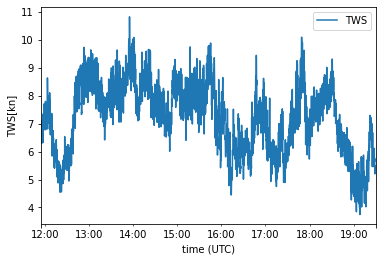

In [13]:
tws_df.plot(x='_time',y='_value', label='TWS')
plt.ylabel('TWS[kn]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

### True Wind Angle Data

In [14]:
twa_flux = '''
    from(bucket: "nmea")
        |> range
''' +   '(start: ' + start_time + ', stop: ' + stop_time + ')' + '''
        |> filter(fn: (r) => r["_measurement"] == "environment")
        |> filter(fn: (r) => r["_field"] == "wind")
        |> filter(fn: (r) => r["prop1"] == "angleTrue")
        |> keep(columns: ["_time", "_value"])
        |> aggregateWindow(every: 
''' +     aggregate_window + ', fn: ' + aggregate_function + ','  + '''
           createEmpty: false)
'''

In [15]:
twa_df = query_api.query_data_frame( twa_flux )

In [16]:
twa_df.head()

,result,table,_start,_stop,_value,_time
0,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,5.576830,2021-05-15 11:54:30+00:00
1,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,5.622653,2021-05-15 11:54:40+00:00
2,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,6.231672,2021-05-15 11:54:50+00:00
3,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,5.942707,2021-05-15 11:55:00+00:00
4,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,9.956448,2021-05-15 11:55:10+00:00


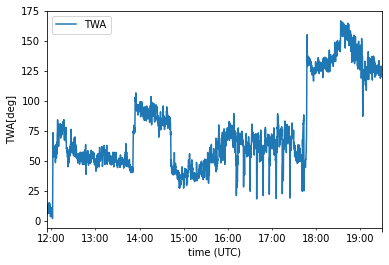

In [17]:
twa_df.plot(x='_time',y='_value', label='TWA')
plt.ylabel('TWA[deg]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

### Speed Through Water Data

In [18]:
stw_flux = '''
    from(bucket: "nmea")
        |> range
''' +   '(start: ' + start_time + ', stop: ' + stop_time + ')' + '''
        |> filter(fn: (r) => r["_measurement"] == "navigation")
        |> filter(fn: (r) => r["_field"] == "speedThroughWater")
        |> keep(columns: ["_time", "_value"])
        |> aggregateWindow(every: 
''' +     aggregate_window + ', fn: ' + aggregate_function + ','  + '''
           createEmpty: false)
'''

In [19]:
stw_df = query_api.query_data_frame( stw_flux )

In [20]:
stw_df.head()

,result,table,_start,_stop,_value,_time
0,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,2.410000,2021-05-15 11:54:30+00:00
1,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,2.370000,2021-05-15 11:54:40+00:00
2,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,2.512857,2021-05-15 11:54:50+00:00
3,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,2.254286,2021-05-15 11:55:00+00:00
4,_result,0,2021-05-15 11:54:21+00:00,2021-05-15 19:30:00+00:00,2.211667,2021-05-15 11:55:10+00:00


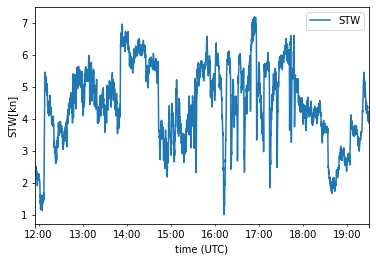

In [21]:
stw_df.plot(x='_time',y='_value', label='STW')
plt.ylabel('STW[kn]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()

##### Close database streaming connection

In [22]:
client.close()

### Reference Polar Data

Your boat's polar in CSV file (not .pol)

In [23]:
pol_df = pd.read_csv("ref_polar.csv", sep=',')

#### Inspecting Polar DataFrame

>**NOTE**: it is a good idea to look how the Panda DataFrame is indexed now: we need to be able to find a label for the column of TWA values. In our example it is `TWA/TWS` while it can be as well something else, like `0` (for 0 kn Wind Speed...) - there is no real standard for this. The example is coming out from Adrena navigation software. You can skip this study once you know your polar file resulting index key.

In [24]:
pol_df.head()

,TWA/TWS,2,4,6,8,10,12,14,16,18,...,24,26,28,30,32,34,36,38,40,60
0,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25,0.70,0.80,0.4,0.4,0.5,0.6,0.7,0.8,0.7,...,1.0,1.1,1.2,1.4,1.5,1.7,1.9,0.0,0.0,0.0
2,30,2.10,2.90,1.4,1.4,1.7,1.8,1.9,2.0,1.9,...,2.2,2.4,2.5,2.9,3.1,3.6,4.1,0.0,0.0,0.0
3,35,2.45,3.00,2.8,2.9,3.5,3.7,3.9,4.0,3.9,...,4.4,4.9,5.1,5.8,6.0,6.5,7.0,0.0,0.0,0.0
4,40,2.50,3.05,3.6,3.7,4.0,4.3,4.4,4.5,4.4,...,5.8,6.1,6.6,7.1,7.3,7.8,8.3,0.0,0.0,0.0


for column_name, item in pol_df.iteritems():
    print(type(column_name))
    print(column_name)
    print('~~~~~~')

    print(type(item))
    print(item)
    print('------')

In [25]:
pol_df = pd.read_csv("ref_polar.csv", sep=',', header=0, index_col='TWA/TWS')

In [26]:
pol_df.head()

,2,4,6,8,10,12,14,16,18,20,...,24,26,28,30,32,34,36,38,40,60
TWA/TWS,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.70,0.80,0.4,0.4,0.5,0.6,0.7,0.8,0.7,0.8,...,1.0,1.1,1.2,1.4,1.5,1.7,1.9,0.0,0.0,0.0
30,2.10,2.90,1.4,1.4,1.7,1.8,1.9,2.0,1.9,2.0,...,2.2,2.4,2.5,2.9,3.1,3.6,4.1,0.0,0.0,0.0
35,2.45,3.00,2.8,2.9,3.5,3.7,3.9,4.0,3.9,4.1,...,4.4,4.9,5.1,5.8,6.0,6.5,7.0,0.0,0.0,0.0
40,2.50,3.05,3.6,3.7,4.0,4.3,4.4,4.5,4.4,4.9,...,5.8,6.1,6.6,7.1,7.3,7.8,8.3,0.0,0.0,0.0


The below block is only needed for better understanding if you so wish

In [27]:
# for column_name, item in pol_df.iteritems():
#     print(type(column_name))
#     print(column_name)
#     print('~~~~~~')

#     print(type(item))
#     print(item)
#     print('------')

We have now clear column (wind) and row (angle) indices obtained from the polar file and not those sequentially autogenerated by Panda.

#### Plotting out TWA/STW polar curves

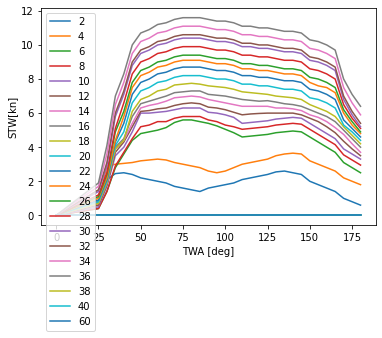

In [28]:
pol_df.plot(label='Polar')
plt.ylabel('STW[kn]')
plt.xlabel('TWA [deg]')
plt.legend()
plt.show()

#### Looking up STW values from the polar DataFrame

We will hardly get values which will fall spot on a cell of the polar file. We need to find group of cells which allows us to extrapolate by averaging the polar value against the floating value measurement value. Below we select test values to develop that:

### Make a subroutine returing polar speed

Note that for performance reasons we expect the polar data having been read from the CSV-file into a Panda DataFrame as explained above - there is no need to open the file for every single TWA and TWS tuple.

In [29]:
def getpolspeed( pol_df, twa, tws ) :
    # print('twa: ', twa, 'tws: ', tws)
    lowertws_coldf = None
    lowertws = None
    uppertws_coldf = None
    uppertws = None

    for column_name, item in pol_df.iteritems():
        pol_tws = float(column_name)
        # print(pol_tws)
        if tws >= pol_tws :
            lowertws_coldf = item
            lowertws = pol_tws
        else :
            if pol_tws >= tws :
                uppertws_coldf = item
                uppertws = pol_tws
                break
    # print('lowertws: ', lowertws, ' type df: ', type(lowertws_coldf))
    # print('uppertws: ', uppertws, ' type df: ', type(uppertws_coldf))

    null_stw      = None
    lowertwa      = None
    uppertwa      = None
    lwrtwa_lwrtws = null_stw
    uprtwa_lwrtws = null_stw
    lwrtwa_uprtws = null_stw
    uprtwa_uprtws = null_stw

    for column_name, item in lowertws_coldf.iteritems():
        pol_twa = float(column_name)
        # print(pol_twa)
        if twa >= pol_twa :
            lwrtwa_lwrtws = item
            lowertwa = pol_twa;
            # print('lowertwa: ', lowertwa, ' lwrtwa_lwrtws: ', lwrtwa_lwrtws)
        else :
            if pol_twa >= twa :
                if type(uprtwa_lwrtws) is type(null_stw) :
                    uprtwa_lwrtws = item
                    uppertwa = pol_twa;
                    # print('uppertwa: ', uppertwa, ' uprtwa_lwrtws: ', uprtwa_lwrtws)

    for column_name, item in uppertws_coldf.iteritems():
        pol_twa = float(column_name)
        # print(pol_twa)
        if twa >= pol_twa :
            lwrtwa_uprtws = item
            # print('lwrtwa_uprtws: ', lwrtwa_uprtws)
        if pol_twa >= twa :
            if type(uprtwa_uprtws) is type(null_stw) :
                uprtwa_uprtws = item
                # print('uprtwa_uprtws: ', uprtwa_uprtws)

    # Here we have the "square" of values in which the extrapolated value is located:

    # print('lowertws: ', lowertws)
    # print('lowertwa: ', lowertwa)
    # print('uppertws: ', uppertws)
    # print('uppertwa: ', uppertwa)
    # print('lwrtwa_lwrtws: ', lwrtwa_lwrtws)
    # print('uprtwa_lwrtws: ', uprtwa_lwrtws)
    # print('lwrtwa_uprtws: ', lwrtwa_uprtws)
    # print('uprtwa_uprtws: ', uprtwa_uprtws)

    # Consider the result being on a 3D plane with four corners, all inequal height.
    # There will be a point on that plane, the height of which is the estimated
    # polar speed for that point:

    # lwrtwa_lwrtws (x)--+-------(x) lwrtwa_uprtws
    #                |   |        |
    #                |   |        |
    #                +--(?)-------+
    #                |   |        |
    # uprtwa_lwrtws (x)--+-------(x) uprtwa_uprtws

    # Taking upper left corner as origin, we will calculate the point's
    # projected elevations.

    # **NOTE**: We can have planes which are sliding down (negative elevations),
    # especially when the wind speed is getting higher and the polar takes average
    # of different sail sets.

    lwrtwa_lwrtws_orig = 0.0
    lwrtwa_uprtws_elev = lwrtwa_uprtws - lwrtwa_lwrtws
    # print('lwrtwa_uprtws_elev: ', lwrtwa_uprtws_elev)
    uprtwa_lwrtws_elev = uprtwa_lwrtws - lwrtwa_lwrtws
    # print('uprtwa_lwrtws_elev: ', uprtwa_lwrtws_elev)
    uprtwa_uprtws_elev = uprtwa_uprtws - lwrtwa_lwrtws
    # print('uprtwa_uprtws_elev: ', uprtwa_uprtws_elev)

    #                    0.0 (x)--+-------(x) 0.2 lwrtwa_uprtws_elev
    #                         |   |        |
    #                         |   |        |
    #                         +--(?)-------+
    #                         |   |        |
    # uprtwa_lwrtws_elev 0.5 (x)--+-------(x) 0.8 uprtwa_uprtws_elev

    tws_ratio = (test_tws - lowertws)/(uppertws - lowertws)
    # print('tws_ratio: ', tws_ratio)

    twa_ratio = (test_twa - lowertwa)/(uppertwa - lowertwa)
    # print('twa_ratio: ', twa_ratio)

    y_lwrtws = twa_ratio * uprtwa_lwrtws_elev
    # print('y_lwrtws: ', y_lwrtws)

    y_uprtws = lwrtwa_uprtws_elev + (twa_ratio * (uprtwa_uprtws_elev - lwrtwa_uprtws_elev))
    # print('y_uprtws: ', y_uprtws)

    x_lwrtws = tws_ratio * lwrtwa_uprtws_elev
    # print('x_lwrtws: ', x_lwrtws)

    x_uprtws = uprtwa_lwrtws_elev + (tws_ratio * (uprtwa_uprtws_elev - uprtwa_lwrtws_elev))
    # print('x_uprtws: ', x_uprtws)

    #                             0.09 x_lwrtws
    #                    0.0 (x)--+-------(x) 0.2 lwrtwa_uprtws_elev
    #                         |   |        |
    #                         |   |        |
    #           y_lwrtws 0.22 +--(?)-------+ 0.46 y_uprtws
    #                         |   |        |
    # uprtwa_lwrtws_elev 0.5 (x)--+-------(x) 0.8 uprtwa_uprtws_elev
    #                             0.64 x_uprtws

    ##### Result

    x_res = x_lwrtws + (x_uprtws - x_lwrtws) * twa_ratio
    # print('x_res: ', x_res)
    # print('result: ', (lwrtwa_lwrtws + x_res))

    ##### Verification

    y_res = y_lwrtws + (y_uprtws - y_lwrtws) * tws_ratio
    # print('y_res: ', y_res)
    if round(y_res,2) != round(x_res,2) :
        printf('WARNING: polar explaration function verification fails: ', x_res, y_res)

    return round((lwrtwa_lwrtws + x_res),2)

##### Test subroutine

In [30]:
test_twa = 37.2
test_tws = 10.9

In [31]:
test_pol_speed = getpolspeed( pol_df, test_twa, test_tws )
print('test_pol_speed: ', test_pol_speed)
if round(test_pol_speed,2) != 3.83 :
    print('getpolspeed test FAIL: was expecting 3.83 with the test polar file')

test_pol_speed:  3.83


In [32]:
test_twa = 60.24671838095237 
test_tws = 6.030811476190476

In [33]:
test_pol_speed = getpolspeed( pol_df, test_twa, test_tws )
print('test_pol_speed: ', test_pol_speed)
if round(test_pol_speed,2) != 5.01 :
    print('getpolspeed test FAIL: was expecting 5.01 with the test polar file')

test_pol_speed:  5.01


### Compare STW dataset to polar values resulting from TWA/TWS values 

Below block can be used to dump-list the data for debugging purposes but its main purpose is to compose a new Panda DataFrame, which will contain the data to be plotted from the retreived and from the processed data, in this case we compare STW to the polar speed.

In [34]:
idx = 0
stwpol_df = pd.DataFrame(columns=['_time', 'stw', 'pol', 'per'])
for row in stw_df.iterrows() :
    # print(twa_df['_time'][idx],' ', twa_df['_value'][idx],' ', tws_df['_value'][idx],' ', )
    polspeed = getpolspeed( pol_df, twa_df['_value'][idx], tws_df['_value'][idx] );
    stwspeed = stw_df['_value'][idx]
    performance = stwspeed / polspeed * 100
    # Something is wrong with the polar or a typhoon hit us if performance is over 120%?
    if performance > 120 :
        performance = None
    else :
        performacne = int(performance)
    stwpol_df =stwpol_df.append({'_time': twa_df['_time'][idx], 'stw': round(stwspeed,2), \
                                 'pol': polspeed, 'per': performance},\
                                 ignore_index=True)
    idx = idx + 1

In [35]:
stwpol_df.head()

,_time,stw,pol,per
0,2021-05-15 11:54:30+00:00,2.41,0.96,NaN
1,2021-05-15 11:54:40+00:00,2.37,0.96,NaN
2,2021-05-15 11:54:50+00:00,2.51,0.96,NaN
3,2021-05-15 11:55:00+00:00,2.25,0.96,NaN
4,2021-05-15 11:55:10+00:00,2.21,0.96,NaN


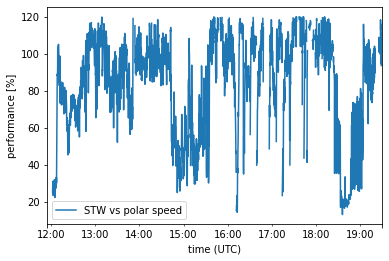

In [36]:
stwpol_df.plot(x='_time',y='per', label='STW vs polar speed')
plt.ylabel('performance [%]')
plt.xlabel('time (UTC)')
plt.legend()
plt.show()